In [1]:
# import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import metrics, preprocessing
import seaborn as sns
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
import warnings
warnings.filterwarnings("ignore")

# Load dataset

In [2]:
#read data
data = pd.read_excel('default of credit card clients.xls')
data.head()
data.shape

(30001, 25)

**Information**

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:<br>
X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.<br>
X2: Gender (1 = male; 2 = female).<br>
X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).<br>
X4: Marital status (1 = married; 2 = single; 3 = others).<br>
X5: Age (year).<br>
X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.<br>
X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005. <br>
X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.



# Preprocess

## Convert Datatype from Object to Int

In [3]:
data=data.drop([0])


In [4]:
df = data.astype(int)
df = df.drop(columns='Unnamed: 0')
df.dtypes

X1     int64
X2     int64
X3     int64
X4     int64
X5     int64
X6     int64
X7     int64
X8     int64
X9     int64
X10    int64
X11    int64
X12    int64
X13    int64
X14    int64
X15    int64
X16    int64
X17    int64
X18    int64
X19    int64
X20    int64
X21    int64
X22    int64
X23    int64
Y      int64
dtype: object

## Delete Outliers

In [5]:
df["X6"][df.X6<1]=-1
df["X7"][df.X7<1]=-1
df["X8"][df.X8<1]=-1
df["X9"][df.X9<1]=-1
df["X10"][df.X10<1]=-1
df["X11"][df.X11<1]=-1
df.shape

(30000, 24)

# Standardization

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
# Divide the whole data to 2 parts, 80% as training set, 20% as test set
train,test=train_test_split(df,test_size=0.2,random_state=0,stratify=df['Y'])

train_X=train[train.columns[:-1]]
train_y=train[train.columns[-1]]

test_X=test[test.columns[:-1]]
test_y=test[test.columns[-1]]

In [8]:
scaler = StandardScaler()
train_X = pd.DataFrame(scaler.fit_transform(train_X), columns=train_X.columns)
test_X = pd.DataFrame(scaler.fit_transform(test_X), columns=test_X.columns)


In [9]:
train_X

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23
0,1.181870,-1.240623,-1.079839,0.858477,-1.029674,-0.512063,-0.409703,-0.395840,-0.353658,-0.323191,...,-0.478122,-0.486032,-0.666427,-0.656171,-0.264078,-0.181775,-0.296122,-0.311500,-0.312013,12.249169
1,0.252354,-1.240623,-1.079839,-1.060800,0.494083,-0.512063,-0.409703,-0.395840,-0.353658,-0.323191,...,-0.586932,-0.634081,-0.569042,-0.030126,-0.041420,0.050646,-0.153340,0.077286,0.839939,-0.017405
2,-0.367323,0.806047,-1.079839,0.858477,1.038281,-0.512063,-0.409703,-0.395840,-0.353658,-0.323191,...,0.587722,0.722846,0.909079,0.987761,-0.156202,-0.117812,-0.115437,0.155043,-0.077757,-0.075234
3,-1.141920,0.806047,-1.079839,0.858477,-1.465033,-0.512063,-0.409703,-0.395840,-0.353658,-0.323191,...,-0.665491,-0.670154,-0.666427,-0.651072,-0.339508,-0.215673,-0.292458,-0.311500,-0.292362,0.140115
4,-1.064461,0.806047,1.450909,-1.060800,0.711762,-0.512063,-0.409703,-0.395840,-0.353658,-0.323191,...,-0.485926,-0.634517,-0.169698,-0.164117,-0.257886,-0.202881,-0.250651,1.632431,-0.243949,-0.218382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,-0.677162,0.806047,0.185535,-1.060800,0.167563,-0.512063,-0.409703,-0.395840,-0.353658,-0.323191,...,-0.042160,0.033160,0.137064,0.186146,-0.041836,-0.125780,-0.190582,-0.052310,-0.181871,-0.183593
23996,-0.057485,0.806047,0.185535,-1.060800,-0.267796,-0.512063,-0.409703,-0.395840,-0.353658,-0.323191,...,-0.539935,0.143967,-0.545389,-0.618862,-0.193470,0.170560,2.847194,-0.211323,-0.168206,-0.297655
23997,-0.599703,0.806047,0.185535,-1.060800,1.255961,-0.512063,-0.409703,-0.395840,-0.353658,-0.323191,...,-0.263151,-0.227129,-0.184834,-0.158968,-0.220439,-0.168853,-0.190582,-0.181905,-0.181871,-0.183593
23998,-0.909541,0.806047,0.185535,0.858477,-0.703155,1.236090,2.197332,2.258332,2.451911,-0.323191,...,0.028263,0.073175,0.142973,0.154696,-0.339508,-0.061171,-0.310719,-0.198040,-0.199050,-0.128216


In [10]:
train_y

6671     0
12887    1
16219    0
5773     0
22647    1
        ..
25589    0
258      0
8604     0
12913    1
20374    1
Name: Y, Length: 24000, dtype: int64

# Nueral network (Fully connected)

## Hidden layer size test
- Number of layers

- Number of neurons in each layer

### 1 hidden layer (20, 200, 5)

In [11]:
from sklearn.neural_network import MLPClassifier

In [12]:
neurons=range(20,200,5)
f1_scores=[]
N=[]
for n in neurons:
    clf = MLPClassifier(solver='adam',activation = 'identity',max_iter = 100,alpha = 1e-5,hidden_layer_sizes = (int(n),),random_state = 1)
    clf.fit(train_X,train_y)
    prediction=clf.predict(test_X)
    N.append(n)
    f1_scores.append(f1_score(prediction,test_y,average='weighted'))
    #print("The prediction values are: ",prediction)
    #print('The f1_score of ',str(s),' is',f1_score(prediction,test_y,average='weighted'))

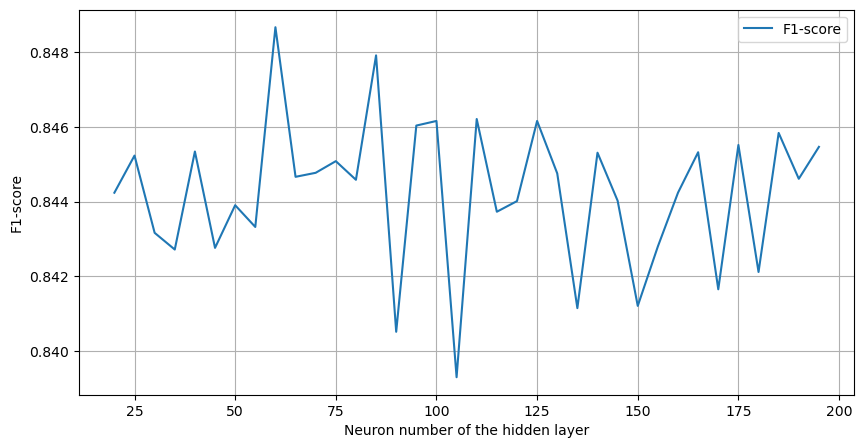

In [13]:
fig2=plt.figure(figsize=(10, 5))
x = N
plt.plot(x,f1_scores, label = 'F1-score')

#plt.xscale('symlog')
plt.xlabel('Neuron number of the hidden layer')
plt.ylabel('F1-score')

plt.grid()
plt.legend()

Highest F1 score appears when there are 60 nerons in the hidden layer.

In [14]:
clf.get_params([clf])

{'activation': 'identity',
 'alpha': 1e-05,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (195,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 100,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 1,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

### 2 hidden layers (20, 200, 5)

In [15]:
neurons=range(20,200,5)
f1_scores=[]
N=[]
for n in neurons:
    clf = MLPClassifier(solver='adam',activation = 'identity',max_iter = 100,alpha = 1e-5,hidden_layer_sizes = (int(n),int(n),),random_state = 1)
    clf.fit(train_X,train_y)
    prediction=clf.predict(test_X)
    N.append(n)
    f1_scores.append(f1_score(prediction,test_y,average='weighted'))
    #print("The prediction values are: ",prediction)
    #print('The f1_score of ',str(s),' is',f1_score(prediction,test_y,average='weighted'))

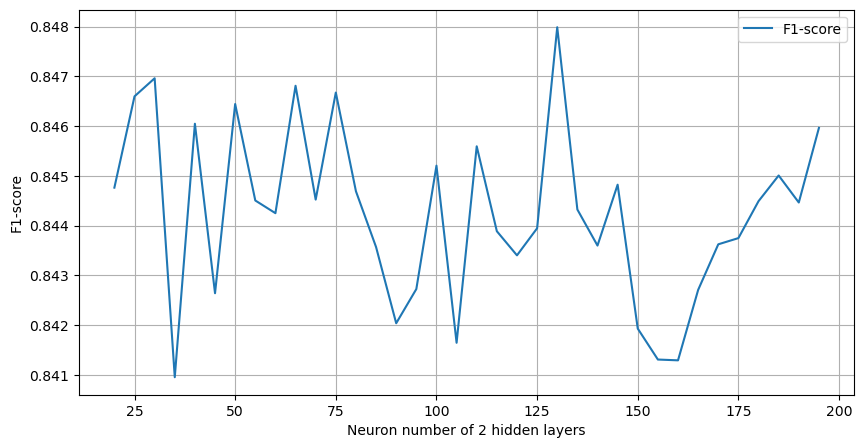

In [16]:
fig2=plt.figure(figsize=(10, 5))
x = N
plt.plot(x,f1_scores, label = 'F1-score')

#plt.xscale('symlog')
plt.xlabel('Neuron number of 2 hidden layers')
plt.ylabel('F1-score')

plt.grid()
plt.legend()

Highest F1 score appears when there are 130 nerons in each hidden layer.

### 3 hidden layers (100, 10~90, 100)

In [17]:
neurons=range(10,90,2)
f1_scores=[]
N=[]
for n in neurons:
    clf = MLPClassifier(solver='adam',activation = 'identity',max_iter = 100,alpha = 1e-5,hidden_layer_sizes = (100,int(n),100),random_state = 1)
    clf.fit(train_X,train_y)
    prediction=clf.predict(test_X)
    N.append(n)
    f1_scores.append(f1_score(prediction,test_y,average='weighted'))
    #print("The prediction values are: ",prediction)
    #print('The f1_score of ',str(s),' is',f1_score(prediction,test_y,average='weighted'))

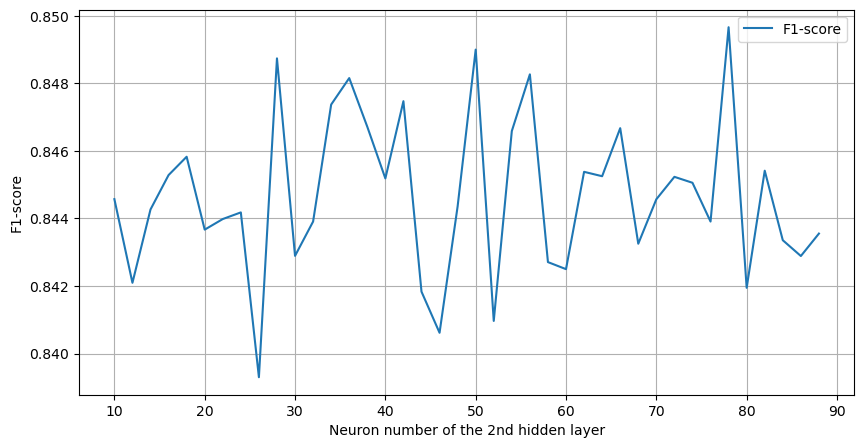

In [18]:
fig2=plt.figure(figsize=(10, 5))
x = N
plt.plot(x,f1_scores, label = 'F1-score')

#plt.xscale('symlog')
plt.xlabel('Neuron number of the 2nd hidden layer')
plt.ylabel('F1-score')

plt.grid()
plt.legend()

In [19]:
max(f1_scores)

0.8496644717972963

Highest F1 score appears when there are 78 nerons in the 2nd hidden layer.

## rule-of-thumb methods

- The number of hidden layer neurons are 2/3 (or 70% to 90%) of the size of the input layer. If this is insufficient then number of output layer neurons can be added later on.[1]
- The number of hidden layer neurons should be less than twice of the number of neurons in input layer. [2]
- The size of the hidden layer neurons is between the input layer size and the output layer size.[3]

[1] Boger, Z., and Guterman, H., 1997, "Knowledge extraction from artificial neural network models," IEEE Systems, Man, and Cybernetics Conference, Orlando, FL, USA <br>
[2] Berry, M.J.A., and Linoff, G. 1997, Data Mining Techniques, NY: John Wiley & Sons <br>
[3] Blum, A., 1992, Neural Networks in C++, NY: Wiley.

**Input layer size: 23 <br>
Output layer size: 2**

In [22]:
neurons=range(2,14,1)
f1_scores=[]
N=[]
for n in neurons:
    clf = MLPClassifier(solver='adam',activation = 'identity',max_iter = 100,alpha = 1e-5,hidden_layer_sizes = (15,int(n),15),random_state = 1)
    clf.fit(train_X,train_y)
    prediction=clf.predict(test_X)
    N.append(n)
    f1_scores.append(f1_score(prediction,test_y,average='weighted'))
    #print("The prediction values are: ",prediction)
    #print('The f1_score of ',str(s),' is',f1_score(prediction,test_y,average='weighted'))

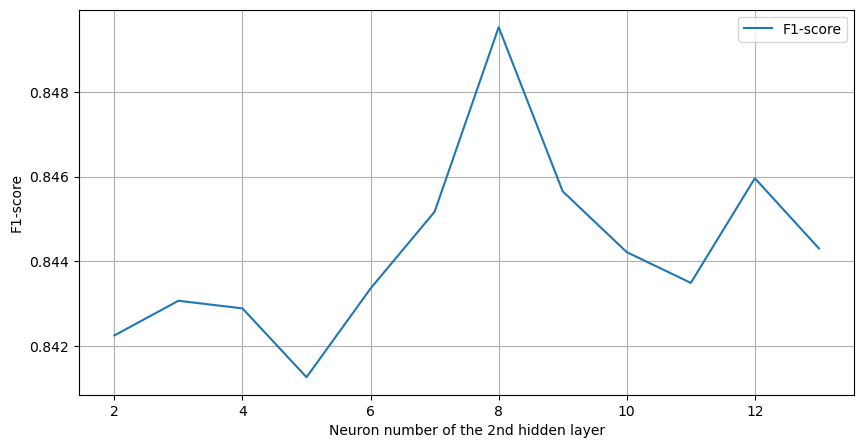

In [23]:
fig2=plt.figure(figsize=(10, 5))
x = N
plt.plot(x,f1_scores, label = 'F1-score')

#plt.xscale('symlog')
plt.xlabel('Neuron number of the 2nd hidden layer')
plt.ylabel('F1-score')

plt.grid()
plt.legend()

In [24]:
max(f1_scores)

0.8495291304924375